## ISRC Python Workshop 3: Topic Modeling (Apr. 06th 2017)

Text data is a great source for data analysis: sentiment analysis, topic retrieval, and so force. In this section, we will be covering a common precedure to conduct some basic analyses on text data retrieved from Scopus API. If you are interested in how to setup and get your own Twitter scraper work, please refer to the <a href="https://nbviewer.jupyter.org/github/zhiyzuo/uiowa-isrc-python/blob/master/2_web_scraping.ipynb">previous IPython Notebook</a> for more details on web data retrieval.

### 0. Retrieving Text Data

In [ ]:
## suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with open("data/scopus_apikey.csv", "r") as f:
    key = f.read().strip()

In [ ]:
from pyscopus.scopus import Scopus
## Supply your own key here.
scopus = Scopus(key)

In [ ]:
## retrieve scopus ids and titles
results = scopus.search_venue(count = 5000, year_range=(2014,2016), \
                              sort_by='relevancy', show=False, \
                              venue_title='Journal of Machine Learning Research')

In [ ]:
abstracts = []
for item in results:
    abstracts.append(scopus.retrieve_abstract(scopus_id=item))

### Text Mining

Specifically, three popular clustering algorithms have been used to mine the underlying topical structures:

(i) <a href="https://www.datascience.com/blog/introduction-to-k-means-clustering-algorithm-learn-data-science-tutorials" target="_blank">K-means</a>

(ii) Latent Semantic Analysis (LSA) [1]

(iii) <span style="color:red">Latent Dirichlet Allocation (LDA)</span> [2]

We will not cover WHAT these algorithms are, but it is good to understand the basics of the assumptions and the mechanisms.

###### In this workshop, we will use implementations of LDA mentioned above from package <a href="http://scikit-learn.org/stable/" target="_blank">scikit-learn</a>

### 1. Preprocessing Text Data (Data Cleaning)

Before we do anything with the fancy algorithms, we must keep in mind that the most important step is to clean the data. Real-world data has many noises in it. We may get results that do not make any sense without proper preprocessing.

In [8]:
import numpy as np

In [1]:
## Let's look at the data first
with open('data/corpus.csv', 'r') as f:
    corpus = [text.replace('\r', '').replace('"','') \
              for text in f.read().split('\n')\
              if len(text) > 0]

In [2]:
## Show 3 abstracts
for doc in corpus[:3]:
    print(doc)
    print('--------------')

Many real-world applications require varying costs for different types of mis-classification errors. Such a cost-sensitive classification setup can be very different from the regular classification one, especially in the multiclass case. Thus, traditional meta-algorithms for regular multiclass classification, such as the popular one-versus-one approach, may not always work well under the cost-sensitive classification setup. In this paper, we extend the one-versus-one approach to the field of cost-sensitive classification. The extension is derived using a rigorous mathematical tool called the cost-transformation technique, and takes the original one-versus-one as a special case. Experimental results demonstrate that the proposed approach can achieve better performance in many cost-sensitive classification scenarios when compared with the original one-versus-one as well as existing cost-sensitive classification algorithms. Reduction from cost-sensitive multiclass classification to one-ve

#### Bag of words
We do not really care the order of the words. We consider each document a <a href="https://en.wikipedia.org/wiki/Bag-of-words_model" target="_blank">bag of words</a>.

In [3]:
## scikit-learn provides convenient functions to preprocess data
from sklearn.feature_extraction.text import CountVectorizer
## remove stop words, which are some common words like I, you, and we.
counter = CountVectorizer(max_df=0.95, min_df=2, \
                                stop_words='english')
corpus_counter = counter.fit_transform(corpus)
counter.get_feature_names()[:15]

[u'2008',
 u'2011',
 u'2013',
 u'97',
 u'able',
 u'access',
 u'account',
 u'accuracy',
 u'accurate',
 u'achieve',
 u'achieves',
 u'active',
 u'actually',
 u'acyclic',
 u'adapt']

In [4]:
len(counter.get_feature_names())

917

However, this seems not reasonable: (i) we probably do not want numbers; (ii) words in different forms are redundant (`achieve` and `achieves` are basically the same thing).

In [5]:
## first remove numbers
from string import digits
corpus_nodigits = [doc.translate(None, digits) for doc in corpus]

Let's try the `CountVectorizer` again.

In [6]:
## stemming: get the `stem` of the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
corpus_for_stem = [doc.split() for doc in corpus_nodigits]
corpus_stemmed_nodigits = [' '.join([stemmer.stem(word) for word in doc])\
                            for doc in corpus_for_stem]

In [9]:
counter = CountVectorizer(max_df=0.95, min_df=2, \
                                stop_words='english')
## corpus_counter is a doc-term sparse matrix
corpus_counter = counter.fit_transform(corpus_stemmed_nodigits)
print(corpus_counter.shape)
words = np.asarray(counter.get_feature_names())
print(words.shape)

(80, 789)
(789,)


In [10]:
counter.get_feature_names()[:15]

[u'abl',
 u'access',
 u'account',
 u'accur',
 u'accuraci',
 u'accuracy',
 u'achiev',
 u'activ',
 u'actual',
 u'acycl',
 u'ad',
 u'adapt',
 u'addit',
 u'addition',
 u'additionally']

### 2. Some summary statistics (Know your data)

In [8]:
## Top 5 words of each document and their frequencies
## NOTE: toarray is not recommended. This is just for illustration purpose.
top_word_indices = np.argsort(-corpus_counter.toarray())[:, :5]
top_words = [words[top_word_indices[index,:]] \
             for index in range(top_word_indices.shape[0])]
top_word_frequency = [corpus_counter[index, top_word_indices[index]].toarray() \
             for index in range(top_word_indices.shape[0])]
print(top_words[:3])
print(top_word_frequency[:3])

[array([u'cost', u'classif', u'sensit', u'approach', u'multiclass'], 
      dtype='<U14'), array([u'variat', u'model', u'infer', u'method', u'box'], 
      dtype='<U14'), array([u'variat', u'bayesian', u'model', u'construct', u'support'], 
      dtype='<U14')]
[array([[8, 8, 6, 3, 3]]), array([[7, 6, 5, 5, 4]]), array([[5, 4, 2, 2, 2]])]


#### Word Cloud
See https://github.com/amueller/word_cloud.

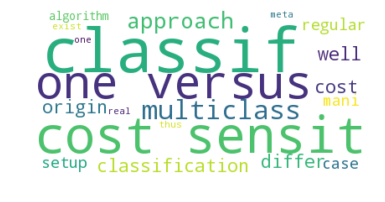

In [16]:
from wordcloud import WordCloud
## plot the first document
wordcloud = WordCloud(background_color="white", max_words=20)
wordcloud.generate(corpus_stemmed_nodigits[0])
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3. Run LDA

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
## large n will produce fine-grained topics
## small n will produce coarse-grained topics
lda = LatentDirichletAllocation(n_topics=5)
corpus_lda = lda.fit_transform(corpus_counter)

/Users/zhiyzuo/.virtualenvs/PyEnv/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [13]:
def print_top_words(model, feature_names, n_top_words):
    top_word_list = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_words = [feature_names[i] \
                     for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(" ".join(top_words))
        top_word_list.append(top_words)
        
    return top_word_list

In [14]:
top_word_list = print_top_words(lda, words, 10)

Topic #0:
class learn thi size equival data markov dimension approach set
Topic #1:
data label learn model function algorithm thi stream set use
Topic #2:
thi algorithm data cluster use problem method model learn estim
Topic #3:
algorithm learn problem use thi bound method function sampl model
Topic #4:
data model method learn thi infer use propos variat machin


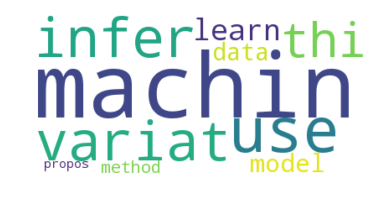

In [17]:
lda_wordcloud = WordCloud(background_color="white", max_words=10, relative_scaling=0)
lda_wordcloud.generate(' '.join(top_word_list[4]))
import matplotlib.pyplot as plt
plt.imshow(lda_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
print(lda.components_)
print(lda.components_.shape)

[[ 0.40434032  0.3684704   0.35107134 ...,  5.23276586  0.3734939
   1.13729281]
 [ 0.42525372  0.33952421  0.35985204 ...,  1.17029832  0.40808637
   0.32377033]
 [ 0.35091375  1.17582242  0.36610332 ...,  3.67024033  3.03098443
   1.15579953]
 [ 3.50968539  0.36678288  1.127191   ...,  3.32732841  2.51637274
   0.40427492]
 [ 0.36939509  1.14205867  1.15214277 ...,  2.74948649  0.36806541
   0.35835541]]
(5, 789)


### 4. Conclusion

Of course there are a lot of things to do. We can, for example, compare the document similarity across the latent topic space. To interprete the meaning of the topics corresponding to the top keywords, we may need to rerun LDA with different number of topics. This tutorial provides a simple procedure on how we can conduct text analyses in Python (in this case, dimensionality reduction by mapping document and words onto a lower-dimemnsion topic space).

While `scikit-learn` provides many handy functions to conduct topic modeling, I actually recommend using the `LDA` in package `gensim` (see <a href="https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation" target="_blank">here</a>). One of the reasons is that it is very hard to interprete what the `components_` mean in the trained `LDA` model in `sklearn`: 

Finally, let's try to use a fantastic tool `pyLDAVis`. See <a href="http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb" target="_blank">here</a> for a more detailed example. 

In [14]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-02 18:07:47.607245. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
pyLDAvis.sklearn.prepare(lda, corpus_counter, counter)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      49.931919        1       1  0.033673  0.014841
2      20.782000        1       2  0.011932  0.071924
0      11.774719        1       3 -0.081213 -0.012134
3       9.973946        1       4  0.049986 -0.053080
1       7.537415        1       5 -0.014378 -0.021551, topic_info=     Category       Freq        Term      Total  loglift  logprob
term                                                             
380   Default  75.000000       learn  75.000000  30.0000  30.0000
366   Default  15.000000      kernel  15.000000  29.0000  29.0000
290   Default  39.000000    function  39.000000  28.0000  28.0000
207   Default  25.000000   distribut  25.000000  27.0000  27.0000
104   Default  20.000000     classif  20.000000  26.0000  26.0000
393   Default  10.000000         log  10.000000  25.0000  25.0000
264   Default  12.000000      factor  12.000000  24.0000  24.0000
410   Default  21.000000      markov  21.000000  23.0000  23.0000
586   Default  10.000000     regress  10.000000  22.0000  22.0000
296   Default  25.000000       gener  25.000000  21.0000  21.0000
765   Default  14.000000      variat  14.000000  20.0000  20.0000
515   Default  11.000000       point  11.000000  19.0000  19.0000
160   Default   9.000000        cost   9.000000  18.0000  18.0000
720   Default  18.000000     theoret  18.000000  17.0000  17.0000
131   Default  17.000000     complex  17.000000  16.0000  16.0000
487   Default  29.000000       optim  29.000000  15.0000  15.0000
385   Default  10.000000  likelihood  10.000000  14.0000  14.0000
80    Default  25.000000       bound  25.000000  13.0000  13.0000
232   Default   6.000000     ensembl   6.000000  12.0000  12.0000
623   Default  33.000000       sampl  33.000000  11.0000  11.0000
729   Default  18.000000        time  18.000000  10.0000  10.0000
548   Default  13.000000    properti  13.000000   9.0000   9.0000
721   Default  12.000000      theori  12.000000   8.0000   8.0000
388   Default  20.000000      linear  20.000000   7.0000   7.0000
170   Default  86.000000        data  86.000000   6.0000   6.0000
396   Default  23.000000         low  23.000000   5.0000   5.0000
639   Default   8.000000      sensit   8.000000   4.0000   4.0000
421   Default  58.000000      method  58.000000   3.0000   3.0000
288   Default  21.000000   framework  21.000000   2.0000   2.0000
463   Default  24.000000         new  24.000000   1.0000   1.0000
...       ...        ...         ...        ...      ...      ...
447    Topic5   2.490697         mrf   7.573568   1.4732  -5.2175
601    Topic5   1.356569    research   4.351197   1.4198  -5.8251
593    Topic5   1.745121       relax   5.852676   1.3752  -5.5733
223    Topic5   0.800099   efficient   2.724432   1.3600  -6.3531
97     Topic5   1.167101   character   4.033366   1.3452  -5.9756
576    Topic5   1.818280    recoveri   6.778292   1.2695  -5.5322
548    Topic5   2.953338    properti  13.174333   1.0900  -5.0472
207    Topic5   4.452019   distribut  25.374959   0.8449  -4.6367
380    Topic5   8.108164       learn  75.244376   0.3574  -4.0372
296    Topic5   3.719617       gener  25.357546   0.6658  -4.8165
721    Topic5   2.530863      theori  12.401585   0.9960  -5.2015
382    Topic5   2.095699    learning   8.951562   1.1333  -5.3902
487    Topic5   3.579213       optim  29.920666   0.4619  -4.8550
575    Topic5   1.914365       recov   7.647197   1.2003  -5.4807
80     Topic5   3.127735       bound  25.139611   0.5012  -4.9898
335    Topic5   2.430742      improv  14.452621   0.8026  -5.2419
729    Topic5   2.637602        time  18.796002   0.6215  -5.1602
421    Topic5   3.714914      method  58.861312  -0.1775  -4.8177
675    Topic5   2.469571       spars  17.751885   0.6128  -5.2261
147    Topic5   1.910062  constraint   8.087293   1.1421  -5.4830
724    Topic5   3.932112         thi  83.838699  -0.4744  -4.7609
290    Topic5  

/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-02 18:07:49.170864. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Reference:

[1] Deerwester, S., Dumais, S. T., Furnas, G. W., Landauer, T. K., & Harshman, R. (1990). Indexing by latent semantic analysis. Journal of the American society for information science, 41(6), 391.

[2] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.